In [1]:
#%matplotlib notebook
from pprint import pprint
from utils import create_dataset, LineData
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.style.use('default')

import numpy as np 
import itertools

EYETRACKER_NAME = "EyeTracker:0"
EYETRACKERSTUB_NAME = "EyeTrackerStub"
TARGET_NAME = "Target:0"
WINDOW_SIZE = (800,800)
TRACKING_WINDOW_PROPERTIES = {'position': np.array((351.25, 37.85)), 'size': np.array((341.25, 341.25))}

img = mpimg.imread('./images/background.png') # background image

In [2]:
dataset = create_dataset()
# prune dataset to contain only those with valid eyetracking data...
dataset = {k:data for k, data in dataset.items() if LineData.in_from_source(data, EYETRACKER_NAME)}
dataset = list(sorted([(k,v) for k,v in dataset.items()], key=lambda x: x[0][:3]))
dataset = {k:list(g) for k,g in itertools.groupby(dataset, key=lambda x: x[0][:3])}

loading files...: 105it [00:42,  2.45it/s]


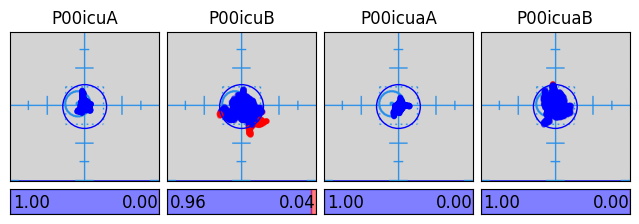

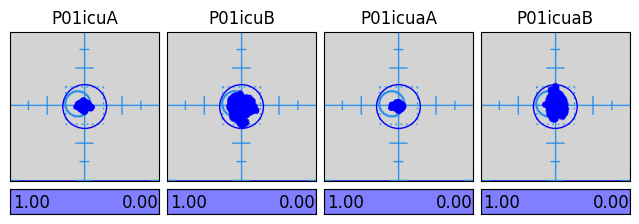

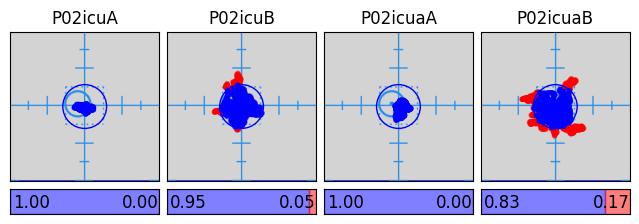

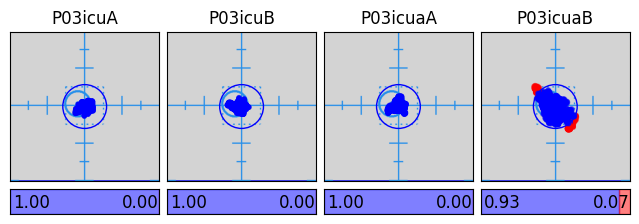

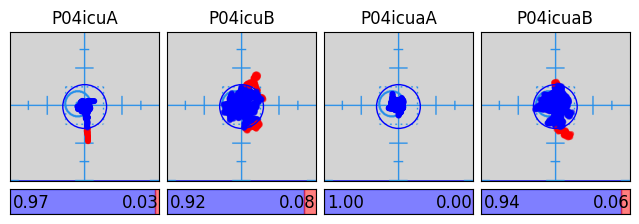

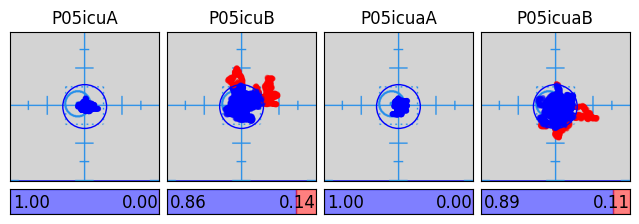

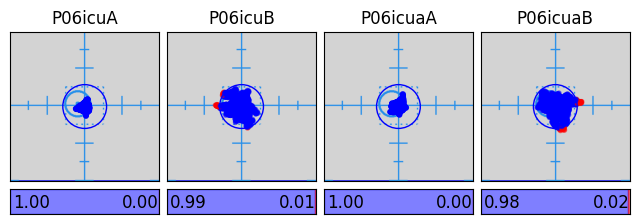

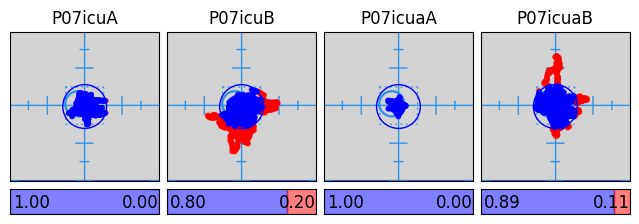

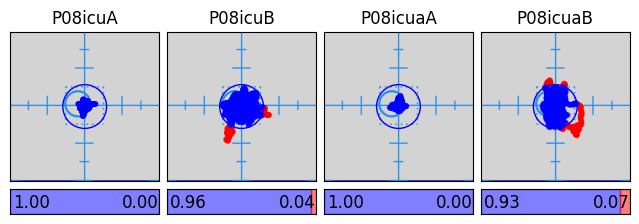

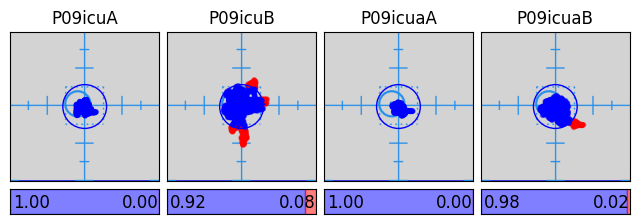

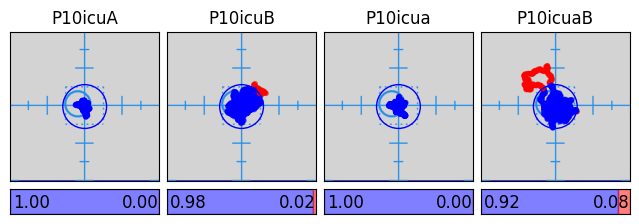

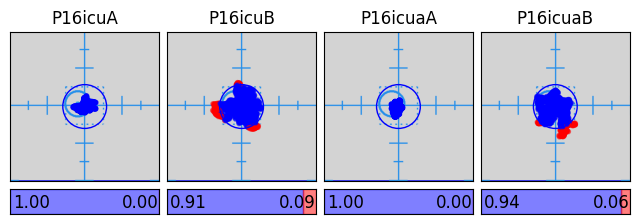

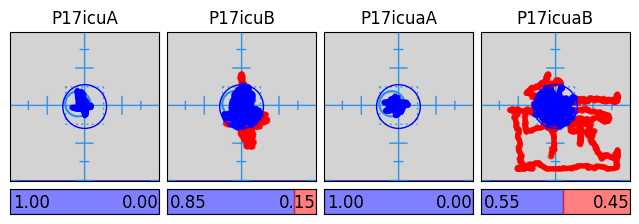

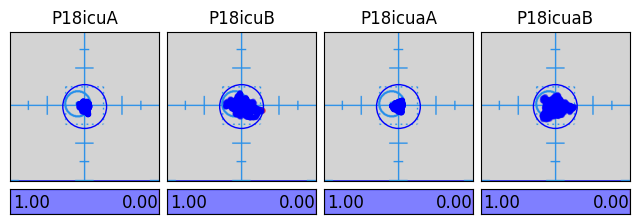

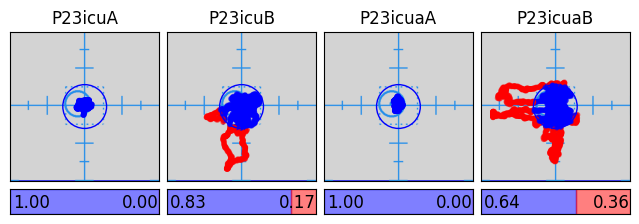

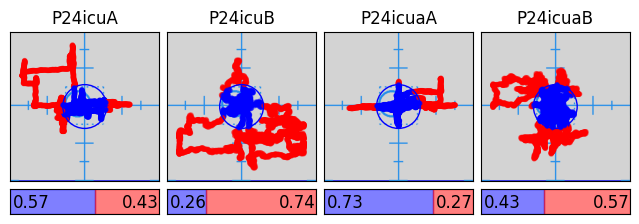

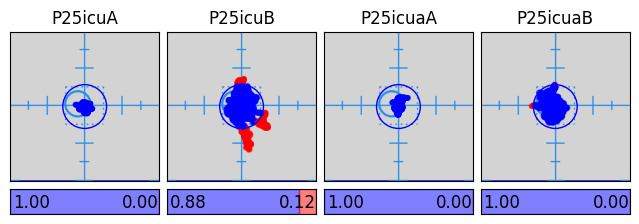

In [80]:
# plot target data
def plot_tracking_task(data, ax, ax_prop, l2_threshold, tracking_window_properties, title):
    def failure_l2(x, y, l2_threshold=50): 
        return np.sqrt(x ** 2 + y ** 2) > l2_threshold
    alpha = 0.5
    tracking_window_center = tracking_window_properties['position'] + tracking_window_properties['size']/2

    target_data = LineData.findall_from_source(data, TARGET_NAME)
    target_data = LineData.pack_variables(target_data, "timestamp", "x", "y")
    target_data = np.array(target_data)
    fail = failure_l2(target_data[:,1], target_data[:,2], l2_threshold=l2_threshold)
    target_data[:,-2:] +=  tracking_window_center # absolute (window) coordinates
    
    ax.imshow(img)
    #ax.plot(*(target_data[:,-2:]).T, color="black", alpha=0.1)
    ax.scatter(*(target_data[:,-2:]).T, marker=".", c=np.array(['blue', 'red'])[fail.astype(int)], alpha=alpha)
    tracking_window_lims = np.stack([tracking_window_properties['position'], tracking_window_properties['position'] + TRACKING_WINDOW_PROPERTIES['size']])
    ax.set_xlim(tracking_window_lims[:,0])
    ax.set_ylim(tracking_window_lims[:,1])
    ax.invert_yaxis()
    ax.set_xticklabels([])
    ax.set_yticklabels([]) 
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    ax.set_title(title.split(".")[0])
    # valid target locations
    circ = plt.Circle(tracking_window_center, l2_threshold, fill=False, color="blue")
    ax.add_patch(circ)
    
    ax_prop.set_xlim(0,1)
    ax_prop.set_ylim(0,1)
    ax_prop.set_xticklabels([])
    ax_prop.set_yticklabels([]) 
    ax_prop.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    # fill proportion out of bounds
    
    prop_fail = fail.sum() / fail.shape[0]
    ax_prop.text(0.02, 0.25, f"{1-prop_fail:.2f}", fontsize=12, color="black")
    ax_prop.text(1-0.25, 0.25, f"{prop_fail:.2f}", fontsize=12, color="black")
    
    ax_prop.axvspan(0, 1-prop_fail, alpha=alpha, color='blue')
    ax_prop.axvspan(1-prop_fail, 1, alpha=alpha, color='red')

    
def plot_proportion(data, ax, l2_threshold):
    pass 
    
def create_subplots(dataset, nrows=1, ncols=4):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8,3),
                            gridspec_kw={'width_ratios':[1,1,1,1], 'height_ratios':[10,1], 
                                         'wspace':0.05, 'hspace':-0.3})
    return fig, axs

L2_THRESHOLD = 50 # default for the icua agents

for (par, group) in dataset.items():
    fig, axs = create_subplots(dataset, nrows=2)
    for (k, data), ax in zip(group, axs.T):
        plot_tracking_task(data, ax[0], ax[1], L2_THRESHOLD, TRACKING_WINDOW_PROPERTIES, k)

    plt.savefig(f"./images/tracking/{par}.png", bbox_inches="tight")
    plt.show()

In [ ]:

for k, data in itertools.islice(dataset.items(), None):    
    eye_data = LineData.findall_from_source(data, EYETRACKER_NAME)
    #print(eye_data[0])
    eye_data = LineData.pack_variables(eye_data, "timestamp", "label", "x", "y", )
    eye_data = np.array(eye_data)
    sac = eye_data[:,1] == "saccade"
    t, x, y = eye_data[:,0].astype(np.float32), eye_data[:,2].astype(np.float32), eye_data[:,3].astype(np.float32)
    
    fig = plt.figure()
    fig.suptitle(k.split(".")[0])
    plt.imshow(img)
    plt.scatter(x,y, alpha=0.1, marker=".", c=np.array(['black', 'white'])[sac.astype(int)])
    #rect = plt.Rectangle((0,0), *WINDOW_SIZE, fill=False)
    #plt.gca().add_patch(rect)
    plt.gca().set_xlim(0,WINDOW_SIZE[0])
    plt.gca().set_ylim(0,WINDOW_SIZE[1])
    plt.gca().set_aspect("equal")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig("./data/images/" + k.split(".")[0] + ".png", bbox_inches="tight")
    plt.close()


In [ ]:
plt.imshow("./data/background.png")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image using imread()
img = mpimg.imread('./data/background.png')

plt.figure()
# Display the image using imshow()
plt.imshow(img)
plt.show()


[-10.    1.2   1.2  -1.2]


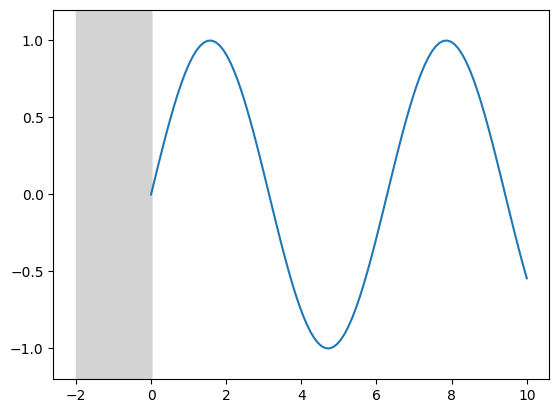

In [46]:

import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Create the plot
fig, ax = plt.subplots()

# Plot the data
ax.plot(x, y)

# Set limits and ticks for the y-axis
ax.set_ylim(-1.2, 1.2)
ax.set_yticks(np.arange(-1, 1.1, 0.5))

# Draw the filled box outside the y-axis
box_coordinates = np.array([[-2, -10], [-2, 1.2], [0, 1.2], [0, -1.2]])
ax.fill_betweenx(box_coordinates[:, 1], box_coordinates[:, 0], color='lightgray')
print(box_coordinates[:,1])
# Display the plot
plt.show()

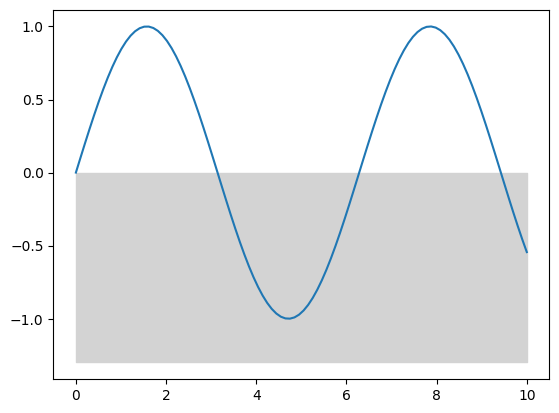

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Create the plot
fig, ax = plt.subplots()

# Plot the data
ax.plot(x, y)

# Draw the filled box outside the plot axis below the x-axis
box_coordinates = np.array([[x.min(), ax.get_ylim()[0]], [x.min(), ax.get_ylim()[0]-0.2],
                            [x.max(), ax.get_ylim()[0]-0.2], [x.max(), ax.get_ylim()[0]]])
ax.fill_between(box_coordinates[:, 0], box_coordinates[:, 1], color='lightgray', zorder=-1)

# Display the plot
plt.show()
